<a href="https://colab.research.google.com/github/bokutachi256/gisday2019/blob/master/2_%E5%82%BE%E6%96%9C%E9%87%8F%E3%81%A8%E6%9B%B2%E7%8E%87%E3%81%AE%E8%A8%88%E7%AE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 事前の準備

## ライブラリのインストール

pyshedsは標準で用意されていないので，
pipを用いてインストールする必要がある．

In [0]:
%pip install pysheds

## ライブラリのインポート

このプログラムでは，以下のライブラリを使用する．


1. cv2：画像処理ライブラリOpenCV
1. numpy：行列計算ライブラリ
1. seaborn：図をきれいに表示するライブラリ
1. matplotlib：図化用ライブラリ
1. google.colab：Google ColaboratoryにGoogle driveをマウントするライブラリ
1. pandas：データフレームを使うためのライブラリ
1. osgeo：GISのラスタ・ベクタ型データを扱うライブラリ
1. pysheds：流路網処理のライブラリ
1. gc:ガベージコレクションのライブラリ



In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
import pandas as pd
import cv2
import gc
from osgeo import gdal, gdalconst, gdal_array
from pysheds.grid import Grid
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+i

## Google Driveのマウント

drive.mountを使ってColaboratoryにGoogle Driveを接続します．
Google Driveはdrive.mountの引数のパスにマウントされます．
今回は自分のGoogle Driveに`gisday2019`フォルダを作成し，
これを作業用のフォルダにします．


In [0]:
drive.mount('/content/drive')
base_dir = "/content/drive/My Drive/gisday2019/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# DEMの読み込み

pyshedsのGridオブジェクトを使用して
GeoTiff形式ののDEMを読み込みます．
具体的には


In [0]:
grid = Grid()


でインスタンスを作成し，
`read_raster`メソッドでGeoTiffファイルを読み込みます．
読み込み元のGeoTiffファイルは，作業用フォルダ`base_dir`にある`06_miyake_dem.tif`です．

In [0]:
grid.read_raster(base_dir + 'miyake_dem_JGD2011_zone9.tif', data_name='dem')

In [0]:
grid.affine[0]

5.0

In [0]:
grid.bbox

(-42320.0, -216950.0, -23820.0, -207840.0)

傾斜量の計算方法



$m \times n$メッシュのDEMを考えます．
ここで，$z$は各メッシュにおける標高です．

$$
\begin{eqnarray}
  DEM &=&
    \begin{bmatrix}
      z_{11} & z_{21} & z_{31} & \ldots & z_{m1}\\
      z_{12} & z_{22} & z_{32} & \ldots & z_{m2}\\
      z_{13} & z_{23} & z_{33} & \ldots & z_{m3}\\
      \vdots & \vdots & \vdots & \ddots & \vdots\\
      z_{1n} & z_{2n} & z_{3n} & \ldots & z_{mn}
   \end{bmatrix}\\
\end{eqnarray}
$$

任意の点$(i, j)$における傾斜量$slope_{ij}$は以下のように定義されます．

$$
  Slope = \sqrt{G^{2}+H^{2}}
$$

$G$および$H$は以下のように定義できます．

$$
\begin{eqnarray}
  G &=& \frac{(-z_{(i-1, j)} + z_{(i+1, j)})}{2d}\\
  H &=& \frac{(z_{(i, j-1)} - z_{(i, j+1)})}{2d}\\
\end{eqnarray}
$$

$d$はメッシュ間隔になりますので，
メッシュ間隔$d$はGeoTiff画像のプロパティ`grid.affine`から取得できます．
`grid.affine`の内容を確認してみましょう．．




In [0]:
grid.affine

Affine(5.0, 0.0, -42320.0,
       0.0, -5.0, -207840.0)

In [0]:
grid.nodata

-9999.0

In [0]:
z1 = np.roll(grid.dem, ( 1, 1), axis = (1, 0)) #z1は左上セル
z3 = np.roll(grid.dem, (-1, 1), axis = (1, 0)) #z3は右上セル
z7 = np.roll(grid.dem, ( 1,-1), axis = (1, 0)) #z7は左下セル
z9 = np.roll(grid.dem, (-1,-1), axis = (1, 0)) #z9は右下セル

z4 = np.roll(grid.dem,  1, axis = 1) #z4は左セル
z6 = np.roll(grid.dem, -1, axis = 1) #z6は右セル

z2 = np.roll(grid.dem,  1, axis = 0) #z2は上セル
z8 = np.roll(grid.dem, -1, axis = 0) #ｚ８は下セル

z5 = grid.dem #z5は真ん中セルなのでgrid.demと同じ

In [0]:
d = np.abs(grid.affine[0])


D = ((z4 + z6) / 2) - z5
E = ((z2 + z8) / 2) - z5
F = (z3 + z7 - z9 - z1) / 4*d


G = (-z4 + z6) / 2*d
H = (z2 - z8) / 2*d

In [0]:
slope=np.sqrt((G*G)+(H*H))

plt.figure(figsize=(30,30))
sns.heatmap(slope,cmap='rainbow',square=True,vmax=0.8)
plt.tick_params(labelsize=15)
plt.yticks( np.arange(0, 10000, 1000) )
plt.xticks(np.arange(0,10000,1000))
plt.savefig('slope_b.png')

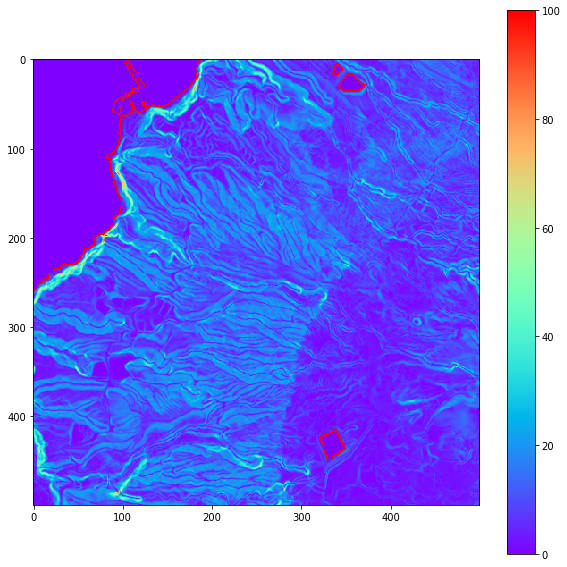

In [0]:
plt.figure(figsize=(10,10))
im=plt.imshow(slope[500:1000, 2000:2500],cmap="rainbow", vmax=100)
plt.colorbar(im)
plt.show()
#plt.savefig('slope_c.png')

行列シフトで何とかなりそう。計算速度が比じゃないくらい早くなった（約５０秒）。細かい計算処理のケアは後ほど。
画像生成は多少時間が取られる（約３分４５秒）。

土砂災害のシミュレーションに直接必要なのはslope。
あとは斜面の曲率や斜面の水平断面の曲率などなど。こちらの計算はBurrough and Mcdonnell(1998)が参考にされている。
地質とかも必要だと思う。


2000年の三宅島噴火では、火山灰が降り積もっての土砂災害（というよりは火山灰の地すべり？）が発生してた。
それに基づいて何か考えたり。
森林の消失によって火山灰を含んだ表土が露出し、雨によって土砂災害があった。

過去の論文での課題を見つけ、それを絡めて三宅島の土砂災害について研究する。

In [0]:
PrC = (2 * ((D * G * G) + (E*H*H) + (F*G*H))) / ((G * G) + (H * H))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


plt.figure(figsize=(15,15))
sns.heatmap(PrC,cmap='gray',square=True)
plt.savefig('PrC_a.png')

容量が大きすぎるのか。そうなのか。ノートPCじゃ不満だと申すか。メモリエラーなあ……どうしたもんか。とりあえず処理を減らして何とかなったが重い。
それと計算結果がうまく言ってる自信がない。なんでや。何が不満だ。

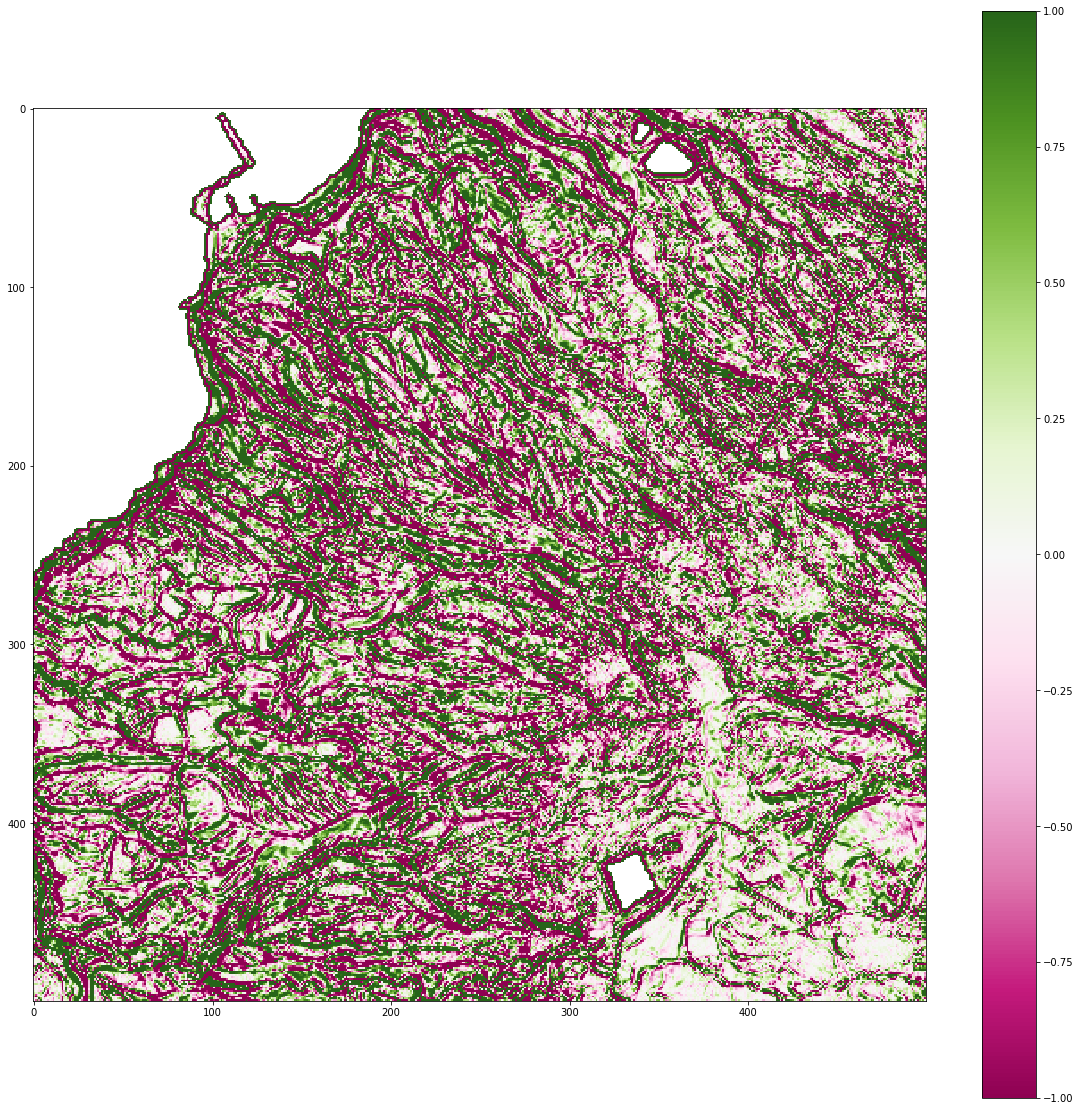

In [0]:
plt.figure(figsize=(20,20))
im=plt.imshow(PrC[500:1000, 2000:2500],cmap="PiYG",vmin=-1,vmax=1)
# im=plt.imshow(PrC2, cmap="PiYG", vmin=-1,vmax=1)

plt.colorbar(im)
plt.show()
#plt.savefig('PrC_b.png')

In [0]:
PrC2 = PrC
PrC2[PrC > 0.15] = 1
PrC2[PrC < -0.15] = -1
PrC2[(PrC <= 0.15) & (PrC >= -0.15)] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


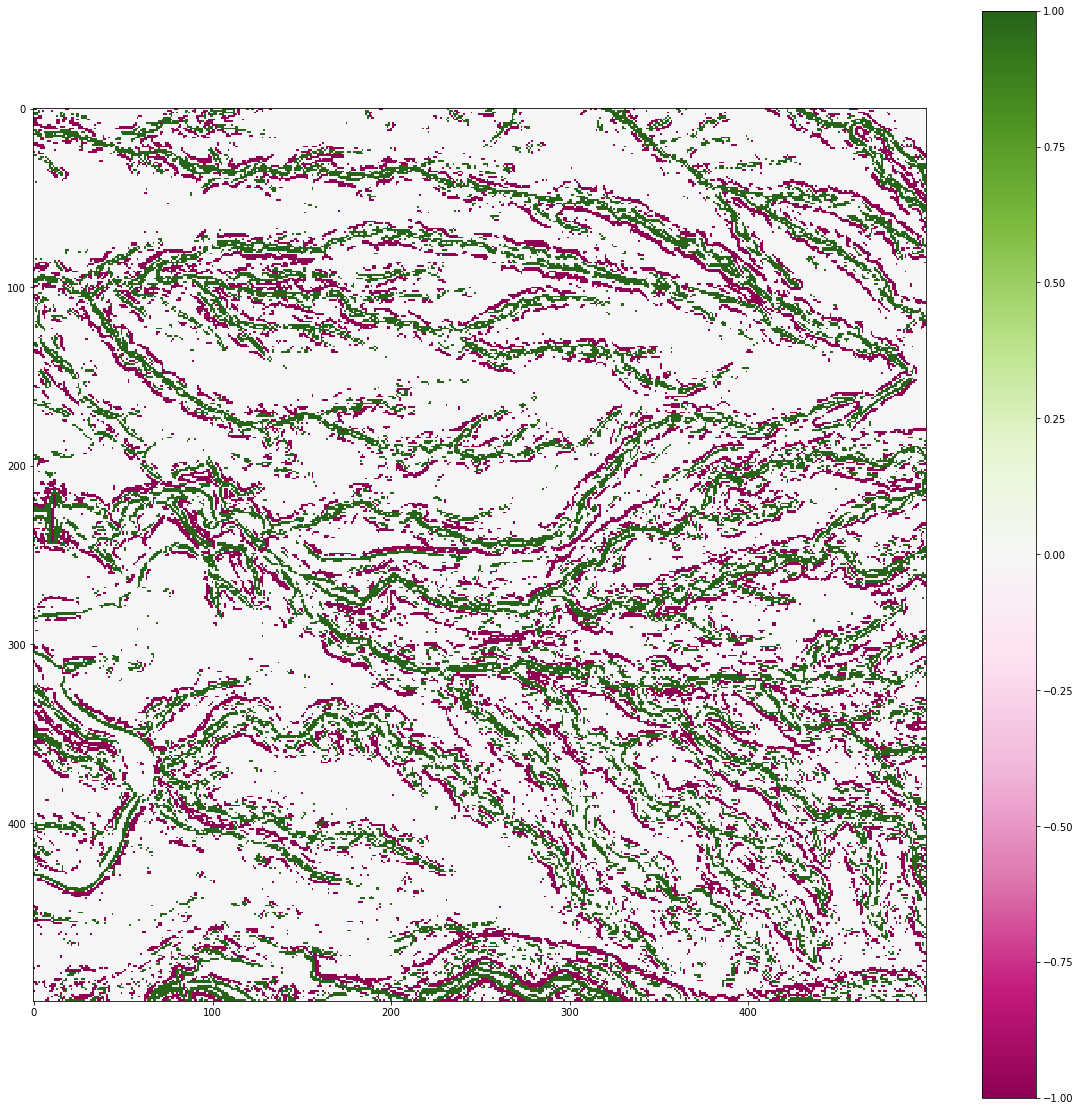

In [0]:
plt.figure(figsize=(20,20))
im=plt.imshow(PrC2[4000:4500, 4000:4500],cmap="PiYG",vmin=-1,vmax=1)
# im=plt.imshow(PrC2, cmap="PiYG", vmin=-1,vmax=1)

plt.colorbar(im)
plt.show()
#plt.savefig('PrC_b.png')

In [0]:
#PlC=((-2*((D*G*G)+(E*H*H)-(F*G*H)))/((G*G)+(H*H)))*100
PlC=((-2*((D*H*H)+(E*G*G)-(F*G*H)))/((G*G)+(H*H)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


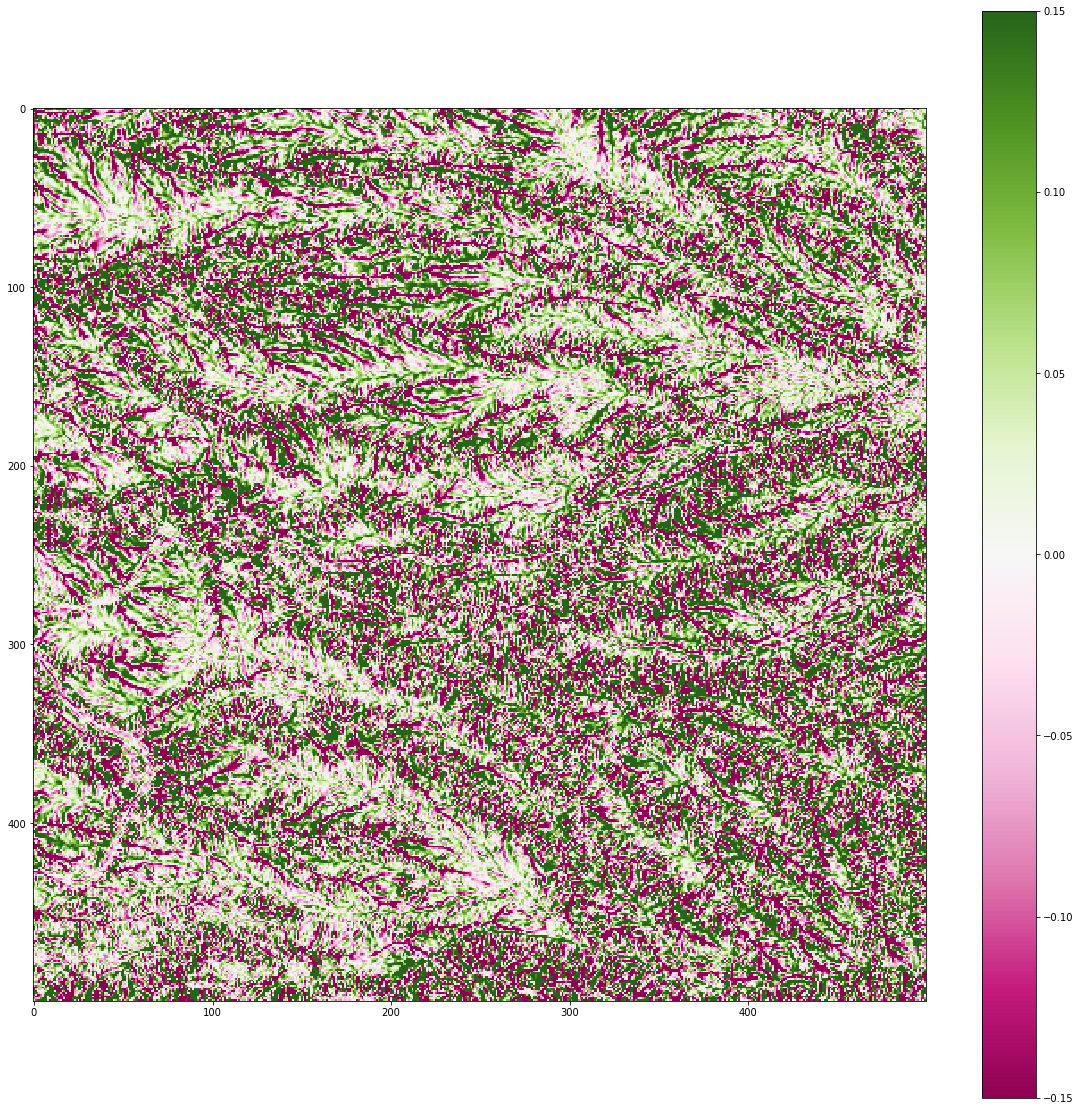

In [0]:
plt.figure(figsize=(20,20))
im=plt.imshow(PlC[4000:4500, 4000:4500],cmap="PiYG",vmin=-0.15,vmax=0.15)
plt.colorbar(im)
plt.show()
#plt.savefig('PlC_b.png')

In [0]:
PlC2 = PlC
PlC2[PlC > 0.05] = 1
PlC2[PlC < -0.05] = -1
PlC2[(PlC <= 0.05) & (PlC >= -0.05)] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


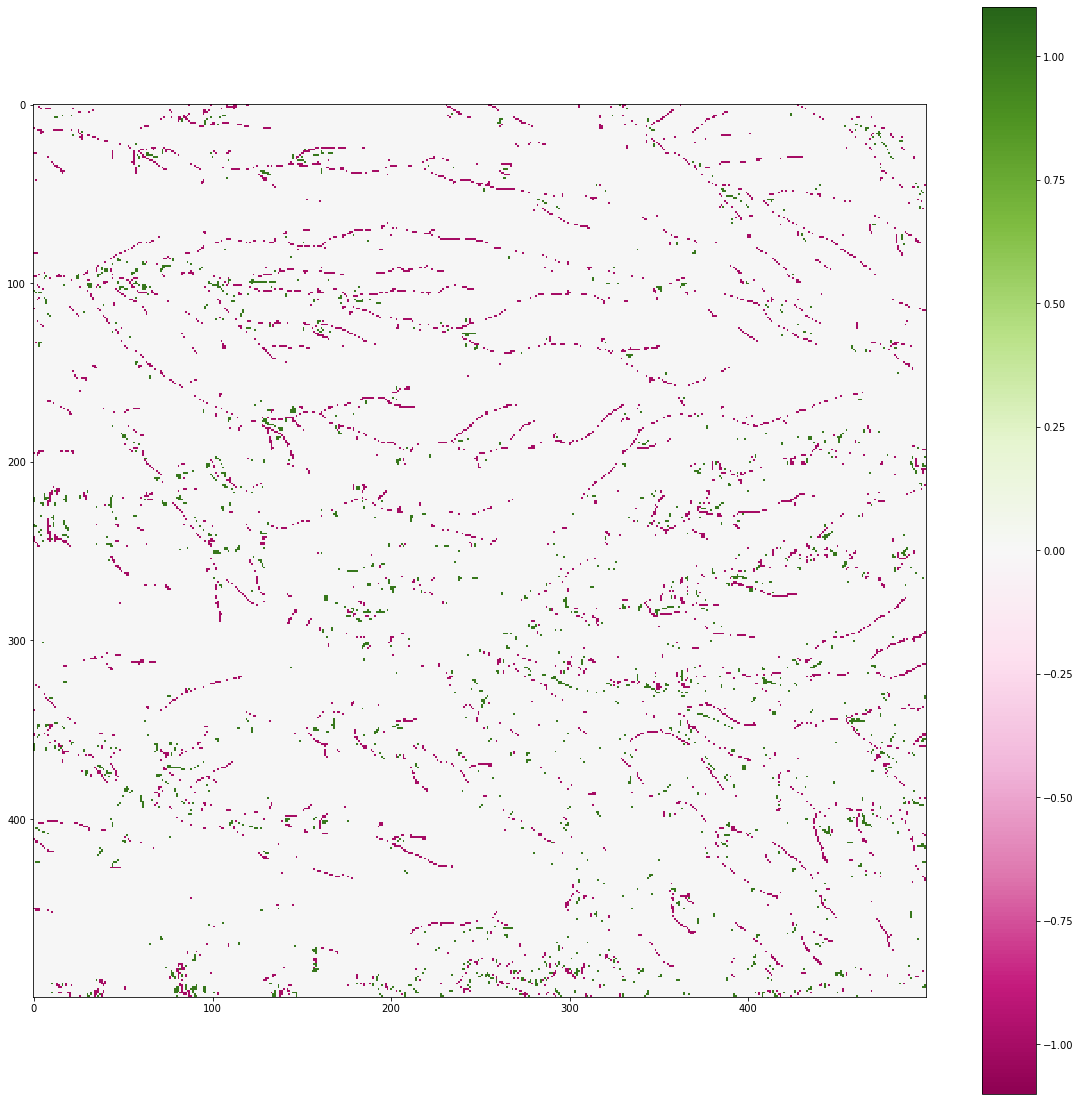

In [0]:
plt.figure(figsize=(20,20))
im=plt.imshow(PlC2[4000:4500, 4000:4500],cmap="PiYG",vmin=-1.1,vmax=1.1)
plt.colorbar(im)
plt.show()
#plt.savefig('PlC_b.png')

図の描画も早くなったーー！

In [0]:
np.max(PlC2)

Raster(nan, dtype=float32)

In [0]:
pd.DataFrame(pd.Series(PrC.ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,61735943,inf,inf,-8.50706e+37,-0.0511681,-5.97389e-05,0.0490585,8.50706e+37
